In [20]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cuda version 9 needed to be installed. with tf-gpu 1.9, keras 2.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Installing custom Keras Retinanet module

In [ ]:
 %cd "/content/drive/My Drive/Pneumonia/rsna-pneumonia/keras-retinanet"   

In [ ]:
pwd #check current path

In [ ]:
!python setup.py build_ext --inplace  #installing keras retinanet

Installing packages of specific versions

In [11]:
pip install pydicom==1.1.0 Keras==2.2.2 keras-resnet==0.1.0 tensorflow-gpu==1.9.0 # you will have to restart runtime after installing

In [ ]:
#Cuda version
!nvcc --version

In [ ]:
#from keras_retinanet.utils.keras_version import check_keras_version

In [7]:
#downgrade cuda to version 9 from 10
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1'''

In [24]:
from keras_retinanet import models

In [25]:
%cd "/content"

/content


In [26]:
"""Utility functions"""

import os
import sys
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
import cv2
sys.path.append("keras-retinanet")
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image


def dicom_to_jpg(in_file, out_file, out_size):
    """ Convert dicom file to jpg with specified size """
    ds = pydicom.read_file(in_file)
    size = (ds.Columns, ds.Rows)
    mode = 'L'
    im = Image.frombuffer(mode, size, ds.pixel_array,
                          "raw", mode, 0, 1).convert("L")
    im = im.resize((out_size, out_size), resample=Image.BICUBIC)
    im.save(out_file, quality=95)


def iou(box1, box2):
    """
    From Yicheng Chen's "Mean Average Precision Metric"
    https://www.kaggle.com/chenyc15/mean-average-precision-metric

    helper function to calculate IoU
    """
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    w1, h1 = x12-x11, y12-y11
    w2, h2 = x22-x21, y22-y21

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max(
        [y11, y21]), min([x12, x22]), min([y12, y22])

    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union


def map_iou(boxes_true, boxes_pred, scores, thresholds=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    From Yicheng Chen's "Mean Average Precision Metric"
    https://www.kaggle.com/chenyc15/mean-average-precision-metric

    Mean average precision at differnet intersection over union (IoU) threshold

    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """

    # According to the introduction, images with no ground truth bboxes will not be
    # included in the map score unless there is a false positive detection (?)

    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None

    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(
            boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]

    map_total = 0

    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1  # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1  # bt has no match, count as FN

        # FP is the bp that not matched to any bt
        fp = len(boxes_pred) - len(matched_bt)
        m = tp / (tp + fn + fp)
        map_total += m

    return map_total / len(thresholds)


def get_annotations(generator):
    """ Return list of annotations from generator """
    annotations = []
    for i in range(generator.size()):
        # load the annotations
        annotation = generator.load_annotations(i)[:, :4]
        annotations.append(annotation)
    return annotations


def get_scores(model, image, scale):
    """ Return calculated bounding boxes and scores for an image """
    # run network
    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image, axis=0))

    # correct boxes for image scale
    boxes /= scale

    image_scores = scores[0]
    image_boxes = boxes[0]

    return (image_boxes, image_scores)


def get_view_from_dicom(dcmfile):
    """ Return ViewPosition dicom field from .dcm file """
    ds = pydicom.read_file(dcmfile)
    return ds.ViewPosition


def get_views_from_generator(generator, dcmdir):
    views = []
    for i in range(generator.size()):
        dcmfile = os.path.basename(generator.image_path(i))[:-4]+".dcm"
        dcmfpath = os.path.join(dcmdir, dcmfile)
        views.append(get_view_from_dicom(dcmfpath))
    return views


def get_detection_from_file(fpath, model, sz):
    image = read_image_bgr(fpath)
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side=sz)
    return get_scores(model, image, scale)


def get_detections_from_generator(generator, model):
    detections = []

    for i in range(generator.size()):
        path = generator.image_path(i)
        raw_image = generator.load_image(i)
        image = generator.preprocess_image(raw_image.copy())
        image, scale = generator.resize_image(image)
        detections.append(get_scores(model, image, scale))
    return detections


def nms(boxes, scores, overlapThresh):
    """
    adapted from non-maximum suppression by Adrian Rosebrock
    https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    """

    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return np.array([]).reshape(0, 4), np.array([])
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # sort the bounding boxes by scores in ascending order
    idxs = np.argsort(scores)

    # keep looping while indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick], scores[pick]


def wt_av(x, xw, y, yw):
    """ Calculate a weighted average """
    return (x*xw+y*yw)/(xw+yw)


def averages(boxes, scores, overlapThresh, solo_min=0):
    """ Like non-max-suppression, but take weighted averages of overlapping bounding boxes """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return np.array([]).reshape(0, 4), np.array([])
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # sort the bounding boxes by scores in ascending order
    idxs = np.argsort(scores)

    # keep looping while indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        overlap_idx = np.where(overlap > overlapThresh)[0].tolist()[::-1]

        if len(overlap_idx) == 0:
            if scores[i] >= solo_min:
                pick.append(i)
        else:
            pick.append(i)
            for j in overlap_idx:
                boxes[i, :] = wt_av(boxes[i, :], scores[i],
                                    boxes[idxs[j], :], scores[idxs[j]])
                scores[i] = scores[i]+scores[idxs[j]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    if len(pick) > 0:
        return boxes[pick], scores[pick]
    else:
        return np.array([]).reshape(0, 4), np.array([])


def intersects(boxes, scores, overlapThresh, solo_min=0, shrink=0):
    """ Like weighted averages, but take intersections of overlapping bounding boxes """

    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return np.array([]).reshape(0, 4), np.array([])
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # sort the bounding boxes by scores in ascending order
    idxs = np.argsort(scores)

    # keep looping while indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        overlap_idx = np.where(overlap > overlapThresh)[0].tolist()[::-1]

        if len(overlap_idx) == 0:
            if scores[i] >= solo_min:
                pick.append(i)

                shrink_factor = shrink/2
                (bx1, by1, bx2, by2) = boxes[i, :]
                diffx = bx2-bx1
                diffy = by2-by1
                boxes[i, 0] += shrink_factor*diffx
                boxes[i, 1] -= shrink_factor*diffx
                boxes[i, 2] += shrink_factor*diffy
                boxes[i, 3] -= shrink_factor*diffy
        else:
            pick.append(i)
            for j in overlap_idx:
                boxes[i, :] = (xx1[j], yy1[j], xx2[j], yy2[j])
                scores[i] = scores[i]+scores[idxs[j]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    if len(pick) > 0:
        return boxes[pick], scores[pick]
    else:
        return np.array([]).reshape(0, 4), np.array([])


def shrink(bb, shrink_factor):
    """ Shrinks bounding boxes by a factor in each dimension """
    if len(bb) > 0:
        x1 = bb[:, 0]
        y1 = bb[:, 1]
        x2 = bb[:, 2]
        y2 = bb[:, 3]
        diffx = x2-x1
        diffy = y2-y1
        shrink_factor /= 2
        x1 += shrink_factor*diffx
        x2 -= shrink_factor*diffx
        y1 += shrink_factor*diffy
        y2 -= shrink_factor*diffy


def overlay_box(im, boxx, rgb, stroke):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    for box in boxx:
        box = [int(b) for b in box]
        
        # --- Extract coordinates
        x1, y1, width, height, = box
        y2 = y1 + height
        x2 = x1 + width

        im[y1:y1 + stroke, x1:x2] = rgb
        im[y2:y2 + stroke, x1:x2] = rgb
        im[y1:y2, x1:x1 + stroke] = rgb
        im[y1:y2, x2:x2 + stroke] = rgb

    return im

def draw(im,boxx,path):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    #d = pydicom.read_file(data['dicom'])
    #im = d.pixel_arraymlcour

    # --- Convert from single-channel grayscale to 3-channel RGB
    #im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present

    

    rgb = np.floor(np.random.rand(3) * 256).astype('int')
    im = overlay_box(im=im, boxx=boxx, rgb=rgb, stroke=10)
    im = Image.fromarray(im)

    #changing image saving path for colab environment
    #im.save('./images/'+"checked_"+path)
    im.save('/content/images/'+"checked_"+path)

    #return im.shape

In [27]:
with open('/content/drive/My Drive/Pneumonia/rsna-pneumonia/settings.json') as json_data_file:
    json_data = json.load(json_data_file)

In [28]:
model1_path = json_data["MODEL_50"]
#join for colab 
model1_path = os.path.join('/content/drive/My Drive/Pneumonia/rsna-pneumonia/',model1_path )
model1 = models.load_model(model1_path, backbone_name='resnet50', convert=True, nms=False)

In [29]:
model2_path = json_data["MODEL_101"]
#join for colab 
model2_path = os.path.join('/content/drive/My Drive/Pneumonia/rsna-pneumonia/',model2_path )
model2 = models.load_model(model2_path, backbone_name='resnet101', convert=True, nms=False)

In [30]:
sz = 224

# threshold for non-max-suppresion for each model
nms_threshold = 0

# shrink bounding box dimensions by this factor, improves test set performance
shrink_factor = 0.17

# threshold for judging overlap of bounding boxes between different networks (for weighted average)
wt_overlap = 0

# threshold for including boxes from model 1
#score_threshold1 = 0.04
score_threshold1 = 0

# threshold for including boxes from model 2
#score_threshold2 = 0.05
score_threshold2 = 0

# threshold for including isolated boxes from either model
solo_min = 0.15

In [31]:
import time
import cv2
import os

In [ ]:
%cd /content

In [ ]:
#create folder to store images
%mkdir images

In [34]:
file_path=[]
score_list1=[]
score_list2=[]

d = "/content/drive/My Drive/Pneumonia/rsna-pneumonia/data/DR - (start from 1)/test/"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        file_path.append(path)
        #fid = fname[:-4]
        start = time.time()
        fpath = d+path

        boxes_pred1, scores1 = get_detection_from_file(fpath, model1, sz)
        boxes_pred2, scores2 = get_detection_from_file(fpath, model2, sz)


        indices1 = np.where(scores1 > score_threshold1)[0]
        scores1 = scores1[indices1]
        boxes_pred1 = boxes_pred1[indices1]
        boxes_pred1, scores1 = nms(boxes_pred1, scores1, nms_threshold)

        indices2 = np.where(scores2 > score_threshold2)[0]
        scores2 = scores2[indices2]
        boxes_pred2 = boxes_pred2[indices2]
        boxes_pred2, scores2 = nms(boxes_pred2, scores2, nms_threshold)

       
        
        #boxes_pred = np.concatenate((boxes_pred1, boxes_pred2))
        #scores = np.concatenate((scores1, scores2))

        #boxes_pred, scores = averages(
        #boxes_pred, scores, wt_overlap, solo_min)
        #shrink(boxes_pred, shrink_factor)
        
        score_list1.append(scores1)
        score_list2.append(scores2)
        
        boxx = []
        #print(boxes_pred,scores)

        for i, bb in enumerate(boxes_pred1):
            x1 = int(bb[0])
            y1 = int(bb[1])
            w = int(bb[2]-x1+1)
            h = int(bb[3]-y1+1)

            boxx.append([x1,y1,w,h])

        im = cv2.imread(fpath)
        draw(im,boxx,path)

In [53]:
print(len(score_list1))

139


In [36]:
score_list1

[array([0.10410278, 0.06090033], dtype=float32),
 array([0.0299483 , 0.0226928 , 0.01229613, 0.0105649 ], dtype=float32),
 array([0.0299483 , 0.0226928 , 0.01229613, 0.0105649 ], dtype=float32),
 array([0.02862005, 0.01522645], dtype=float32),
 array([0.01870739, 0.0161933 ], dtype=float32),
 array([0.01487373, 0.01048843], dtype=float32),
 array([0.01333525], dtype=float32),
 array([0.03437753, 0.01920482, 0.01164582], dtype=float32),
 array([0.03397455, 0.03166102, 0.02188532], dtype=float32),
 array([0.01571011, 0.01487469], dtype=float32),
 array([0.0272428 , 0.01755023], dtype=float32),
 array([0.04546651, 0.02148053, 0.01129013], dtype=float32),
 array([0.04007575, 0.02364794], dtype=float32),
 array([0.04339988, 0.02270057], dtype=float32),
 array([0.02856571, 0.01735566], dtype=float32),
 array([0.0771649 , 0.01792514, 0.01691331], dtype=float32),
 array([0.02970536, 0.01338685], dtype=float32),
 array([0.11501857, 0.06161056, 0.04650594], dtype=float32),
 array([0.01999639, 0.

In [38]:
score_list1  =[arr*100 for arr in score_list1 ]


In [39]:
score_list2  =[arr*100 for arr in score_list2 ]

In [40]:
data = {'col_1': file_path, 'col_2': score_list1}
df=pd.DataFrame.from_dict(data)

In [41]:
df.to_csv('out_model50.csv')

In [42]:
data2 = {'col_1': file_path, 'col_2': score_list2}
df2=pd.DataFrame.from_dict(data2)

In [43]:
df2.to_csv('out_model101.csv')

In [45]:
df.head() #model 50

,col_1,col_2
0,138.jpg,"[10.410278, 6.0900335]"
1,137.jpg,"[2.9948304, 2.2692802, 1.2296134, 1.05649]"
2,139.jpg,"[2.9948304, 2.2692802, 1.2296134, 1.05649]"
3,124.jpg,"[2.8620048, 1.5226455]"
4,125.jpg,"[1.8707392, 1.6193304]"


In [46]:
df2.head() #model 101

,col_1,col_2
0,138.jpg,"[34.510166, 8.1106615]"
1,137.jpg,"[2.2904127, 2.2520986]"
2,139.jpg,"[2.2904127, 2.2520986]"
3,124.jpg,"[1.5367094, 1.455235]"
4,125.jpg,[1.1716628]


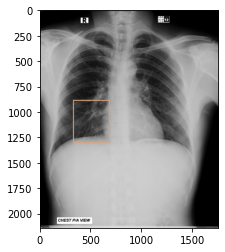

In [52]:
im = plt.imread('/content/images/checked_4.jpg')
plt.imshow(im)